# The libraries used on this script

In [8]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

import laspy
import plotly.graph_objects as go
from plotly.offline import plot




# Loading the data 

In [9]:

# Load LiDAR data
las_file = laspy.read(r'LIDAR\points (7).las')
# Access LiDAR points
lidar_points = las_file.points


# visualizing the data 

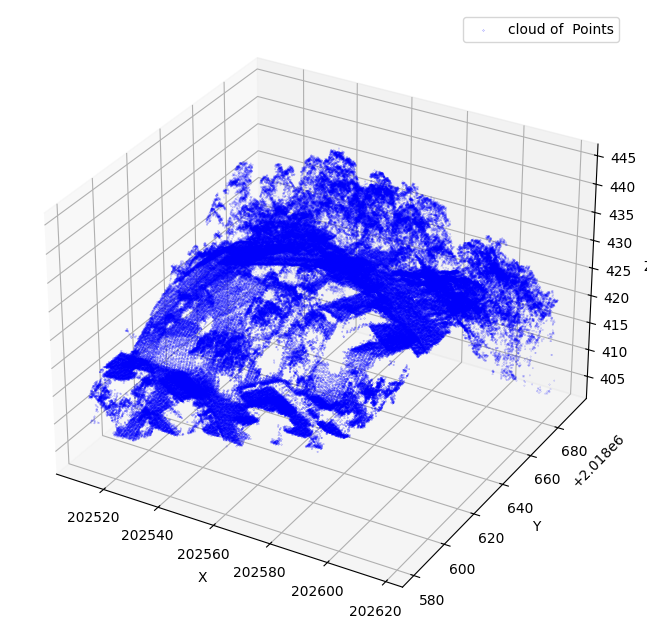

In [10]:


# Extract XYZ coordinates
points = np.vstack((lidar_points.x, lidar_points.y, lidar_points.z)).transpose()

# Plot the points in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', marker='.', s=0.1 ,label='cloud of  Points')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# visualizing the data (denser format)

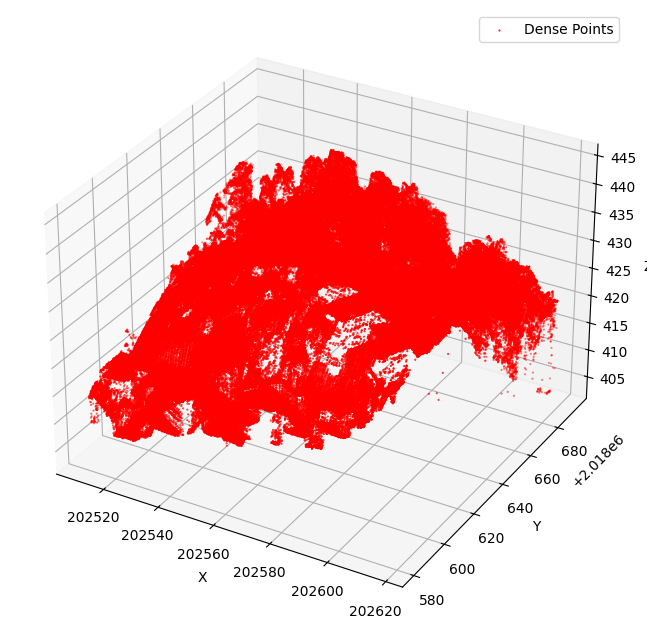

In [42]:
original_point_count = len(lidar_points)
# Extract XYZ coordinates
points = np.vstack((lidar_points.x, lidar_points.y, lidar_points.z)).transpose()


# Create a denser version using linear interpolation
dense_points = np.linspace(0, 1, num=original_point_count * 2)  # Increase the density by a factor of 2
interp_func = interp1d(np.linspace(0, 1, num=original_point_count), points, kind='linear', axis=0)
dense_values = interp_func(dense_points)

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dense_values[:, 0], dense_values[:, 1], dense_values[:, 2], c='red', marker='.', s=1, label='Dense Points')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# visualizing the data (dynamic 3D format on the web  )

In [12]:

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=1),
)])

# Set layout options for the plot
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
)

# Save the interactive plot as an HTML file
html_file_path = "Index.html"
plot(fig, filename=html_file_path, auto_open=False)

# Print a message indicating where the HTML file is saved
print(f"Interactive plot saved to: {html_file_path}")

   


Interactive plot saved to: Index.html


# Extracting the information about the data (we focus on the classification values)

In [46]:
list(lidar_points.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time']

In [47]:
set(list(lidar_points.classification))

{1, 2, 7, 9}

In [44]:
points_dimension = list(lidar_points.point_format.dimension_names)
unique_dimensions = set(points_dimension)
unique_dimensions = list(unique_dimensions)

for i in unique_dimensions:
    variable = i
    unique_dimension_set = set(lidar_points[variable])
    print(f"Set for dimension '{variable}': {unique_dimension_set}")

# Access the second unique dimension
second_unique_dimension = unique_dimensions[1]
print(f"Second unique dimension: {second_unique_dimension}")


Set for dimension 'scan_angle_rank': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -16, -15, -14, -13, -12, -1, -7, -6, -5, -4, -3, -2}
Set for dimension 'X': {20251033, 20251034, 20251035, 20251036, 20251037, 20251038, 20251039, 20251040, 20251041, 20251042, 20251043, 20251044, 20251045, 20251046, 20251047, 20251048, 20251049, 20251050, 20251051, 20251052, 20251053, 20251054, 20251055, 20251056, 20251057, 20251058, 20251059, 20251060, 20251061, 20251062, 20251063, 20251064, 20251065, 20251066, 20251067, 20251068, 20251069, 20251070, 20251071, 20251072, 20251073, 20251074, 20251075, 20251076, 20251077, 20251078, 20251079, 20251080, 20251081, 20251082, 20251083, 20251084, 20251085, 20251086, 20251087, 20251088, 20251089, 20251090, 20251091, 20251092, 20251093, 20251094, 20251095, 20251096, 20251097, 20251098, 20251099, 20251100, 20251101, 20251102, 20251103, 20251104, 20251105, 20251106, 20251107, 20251108, 20251109, 20251110, 20251111, 20251112, 20251113, 20251114, 2025111

# The Machine Learning algorithm 

In [45]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Directory containing your LAS files
las_directory = "LIDAR"

# List all LAS files in the directory
las_files = [file for file in os.listdir(las_directory) if file.endswith(".las")]

# Initialize empty arrays to store features and labels
all_features = np.empty((0, 4), dtype=np.float64)
all_labels = np.empty(0, dtype=np.int32)
# Define class labels based on your provided information
class_labels = {
    0: 'Never classified',
    1: 'Unassigned',
    2: 'Ground',
    3: 'Low Vegetation',
    4: 'Medium Vegetation',
    5: 'High Vegetation',
    6: 'Building',
    7: 'Low Point',
    8: 'Reserved',
    9: 'Water',
    10: 'Rail',
    11: 'Road Surface',
    12: 'Reserved',
    13: 'Wire - Guard (Shield)',
    14: 'Wire - Conductor (Phase)',
    15: 'Transmission Tower',
    16: 'Wire-Structure Connector (Insulator)',
    17: 'Bridge Deck',
    18: 'High Noise',
    19: 'Reserved',
    64: 'User Definable (64)',
    65: 'User Definable (65)',
}

# Read data from each LAS file and concatenate
for las_file in las_files:
    las_file_path = os.path.join(las_directory, las_file)
    las_data = laspy.read(las_file_path)
    
    # Extract features and labels
    features = np.vstack((las_data.x, las_data.y, las_data.z, las_data.intensity)).transpose()
    labels = np.array([list(class_labels.keys()).index(label) for label in las_data.classification])
    
    # Concatenate features and labels to the overall arrays
    all_features = np.concatenate((all_features, features))
    all_labels = np.concatenate((all_labels, labels))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Convert predicted labels back to original class labels
predicted_labels = np.array([list(class_labels.values())[label] for label in predictions])

# Ensure that the target names match the unique classes present in the dataset
target_names = list(class_labels.values())

# Evaluate classification performance
print(classification_report(y_test, predictions, target_names=target_names))


KeyboardInterrupt: 